In [1]:
# standard imports 
import os
import sys
import math
import torch
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt

# import gluon ts distribution head and time feature generation
from gluonts.torch.distributions import StudentTOutput
from gluonts.time_feature import time_features_from_frequency_str

# add lagllama path 
sys.path.append("/home/sbose/lagllama/lag-llama")

# import lagllama specific stuff
from lag_llama.model.module import LagLlamaModel

# function to remove the `model.` prefix from the keys of an ordereddict
clean_keys = lambda od: OrderedDict((k.removeprefix("model."), v) for k, v in od.items())

/home/sbose/.conda/envs/pangu/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
# load the model checkpoint
all_data_ckpt = torch.load("/home/sbose/lagllama/Lag-Llama/lag-llama.ckpt", weights_only=False)
model_kwargs = all_data_ckpt["hyper_parameters"]["model_kwargs"]
loss_fn = all_data_ckpt["hyper_parameters"]["loss"]
weights = clean_keys(all_data_ckpt['state_dict'])

In [3]:
# initialize model and load keys
model = LagLlamaModel(**model_kwargs)
model.load_state_dict(weights)

<All keys matched successfully>

past: torch.Size([1, 1124]), mask_p: torch.Size([1, 1124]), past_time_feat: torch.Size([1, 1124, 6]), future_time_feat: torch.Size([1, 96, 6]).


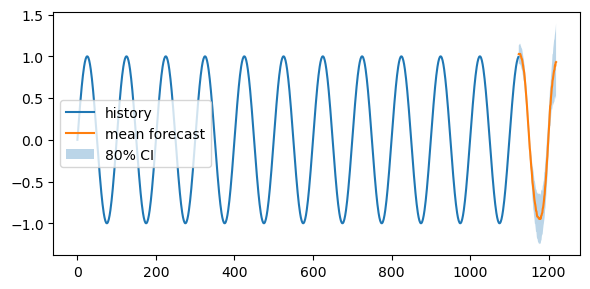

In [21]:
# try a zero shot forecast on a sinusoidal wave

context_len     = model.context_length           # e.g. 192
pred_len        = 96                             # e.g. 24
max_lag         = max(model.lags_seq)            # e.g. 23
past_total_len  = context_len + max_lag  

t = torch.arange(past_total_len + pred_len, dtype=torch.float32)
series = torch.sin(2*math.pi*t/100)                   # period‑50 sine

past   = series[:past_total_len][None]          # (B=1,C=1,L_past)
future = series[past_total_len:][None]          # (1,1,L_future)  (only for teacher forcing check)

mask_p = torch.ones_like(past)                       # every point observed

# generate temporal features
generate_datetime_index = lambda n: pd.date_range(start='2018-01-01 00:00', periods=n, freq='15min')
raw_dt = generate_datetime_index(past_total_len + pred_len)
time_features = time_features_from_frequency_str("s") # bunch of functions that convert a datetime into time features
generated_features = []
for time_feature_fn in time_features:
    generated_features.append(time_feature_fn(raw_dt))
# convert to dataframe
time_features_df = pd.DataFrame(generated_features).T
time_features_df.columns = [f"time_feat_{i}" for i in range(len(time_features))]
time_features_tensor = torch.tensor(time_features_df.values).unsqueeze(0)

# past and future time features
past_time_feat = time_features_tensor[:,:past_total_len,:]
future_time_feat = time_features_tensor[:,past_total_len:,:]

# print shapes of inputs going into the model
print(f"past: {past.shape}, mask_p: {mask_p.shape}, past_time_feat: {past_time_feat.shape}, future_time_feat: {future_time_feat.shape}.")


with torch.no_grad():
    params, loc, scale = model(
        past_target          = past.to(torch.float32),
        past_observed_values = mask_p.to(torch.float32),
        past_time_feat       = past_time_feat.to(torch.float32),
        future_time_feat     = future_time_feat.to(torch.float32),
        future_target        = future.to(torch.float32),                 # inference ⇒ no teacher forcing
        use_kv_cache         = False                 # whole window in one pass
    )

dist = model.distr_output.distribution(params, loc, scale)
samples = dist.sample((1000,))                       # (S, B, L_future) = (1000,1,50)

mean  = samples.mean(0).squeeze()
p10   = samples.quantile(0.1, 0).squeeze()
p90   = samples.quantile(0.9, 0).squeeze()

# --- 4· plot ---------------------------------------------------------
plt.figure(figsize=(6,3))
plt.plot(t[:past_total_len], series[:past_total_len], label="history")
plt.plot(t[past_total_len:], mean[-pred_len:], label="mean forecast")
plt.fill_between(t[past_total_len:], p10[-pred_len:], p90[-pred_len:], alpha=.3, label="80% CI")
plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
mean.shape

torch.Size([32])

In [ ]:
model.scaler.minimum_scale

1e-10

In [ ]:
past.shape

torch.Size([1, 1, 1124])

In [ ]:
model.context_length + max(model.lags_seq)

1124

In [ ]:
mask_p.shape

torch.Size([1, 1124])

In [ ]:
model_kwargs

{'input_size': 1,
 'context_length': 32,
 'max_context_length': 2048,
 'lags_seq': [0,
  7,
  8,
  10,
  11,
  12,
  13,
  14,
  19,
  20,
  21,
  22,
  23,
  24,
  26,
  27,
  28,
  29,
  30,
  34,
  35,
  36,
  46,
  47,
  48,
  50,
  51,
  52,
  55,
  57,
  58,
  59,
  60,
  61,
  70,
  71,
  72,
  83,
  94,
  95,
  96,
  102,
  103,
  104,
  117,
  118,
  119,
  120,
  121,
  142,
  143,
  144,
  154,
  155,
  156,
  166,
  167,
  168,
  177,
  178,
  179,
  180,
  181,
  334,
  335,
  336,
  362,
  363,
  364,
  502,
  503,
  504,
  670,
  671,
  672,
  718,
  719,
  720,
  726,
  727,
  728,
  1090,
  1091,
  1092],
 'n_layer': 8,
 'n_embd_per_head': 16,
 'n_head': 9,
 'scaling': 'robust',
 'distr_output': gluonts.torch.distributions.studentT.StudentTOutput(),
 'num_parallel_samples': 100,
 'rope_scaling': None,
 'time_feat': True,
 'dropout': 0.0}

In [ ]:
past.shape

torch.Size([1, 1124])

In [ ]:
time_features_tensor[:,:past_total_len,:].shape

torch.Size([1, 1124, 6])

In [ ]:
mask_p.shape

torch.Size([1, 1124])